In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
%cd /content/drive/MyDrive/Colab Notebooks/딥러닝

/content/drive/MyDrive/Colab Notebooks/딥러닝


### 학습목표
- 베스트 모델 저장하기 / 불러오기
- 학습 중단 기능
- 과적합 방지 - Dropout


### 베스트 모델 저장하기 / 학습 중단

- 손글씨 이미지 데이터셋
  - 훈련 데이터 6만 개. 테스트 데이터 1만 개
  - 0~9까지 숫자 이미지에 대한 라벨링

In [45]:
from tensorflow.keras.datasets import mnist

(X_train, y_train),(X_test, y_test) = mnist.load_data()

X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

- 데이터 확인

3


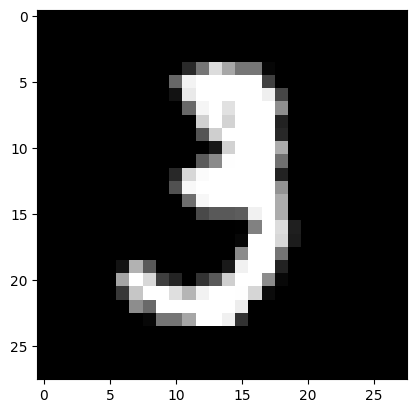

In [46]:
import matplotlib.pyplot as plt

print(y_train[10])
plt.imshow(X_train[10], cmap='gray')
plt.show()

- 이미지 (2차원) -> Dense (1차원) 변환

In [47]:
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

X_train.shape, X_test.shape

((60000, 784), (10000, 784))

- 스케일링 : 0-255 -> 0.0-1.0

In [48]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [49]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

- 라벨 데이터는 원핫인코딩 (다진분류)

In [50]:
from tensorflow.keras.utils import to_categorical

y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)

y_train_oh.shape, y_test_oh.shape

((60000, 10), (10000, 10))

- 신경망 설계

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model1 = Sequential()
# input_dim : 입력 데이터의 크기(X_train의 크기)
model1.add(Dense(512, activation='relu', input_dim=28*28))
# 10 : 라벨 데이터의 크기(y_train의 크기)
model1.add(Dense(10, activation = 'softmax'))

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               401920    
                                                                 
 dense_5 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407050 (1.55 MB)
Trainable params: 407050 (1.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
# validation_data : 테스트 데이터가 있는 경우
# validation_split : 테스트 데이터가 있는 경우 훈련 데이터에서 비율만큼 가져온다.
h1 = model1.fit(X_train, y_train_oh, epochs = 20, batch_size = 128,
                validation_data=(X_test, y_test_oh))

Epoch 1/20
469/469 [==============================] - 12s 23ms/step - loss: 0.2617 - accuracy: 0.9257 - val_loss: 0.1341 - val_accuracy: 0.9622
Epoch 2/20
469/469 [==============================] - 8s 16ms/step - loss: 0.1052 - accuracy: 0.9693 - val_loss: 0.0892 - val_accuracy: 0.9732
Epoch 3/20
469/469 [==============================] - 5s 11ms/step - loss: 0.0680 - accuracy: 0.9806 - val_loss: 0.0744 - val_accuracy: 0.9772
Epoch 4/20
469/469 [==============================] - 5s 11ms/step - loss: 0.0489 - accuracy: 0.9853 - val_loss: 0.0687 - val_accuracy: 0.9790
Epoch 5/20
469/469 [==============================] - 4s 9ms/step - loss: 0.0363 - accuracy: 0.9896 - val_loss: 0.0647 - val_accuracy: 0.9797
Epoch 6/20
469/469 [==============================] - 5s 11ms/step - loss: 0.0260 - accuracy: 0.9926 - val_loss: 0.0670 - val_accuracy: 0.9781
Epoch 7/20
469/469 [==============================] - 5s 11ms/step - loss: 0.0205 - accuracy: 0.9944 - val_loss: 0.0627 - val_accuracy: 0.9803

- 시각화

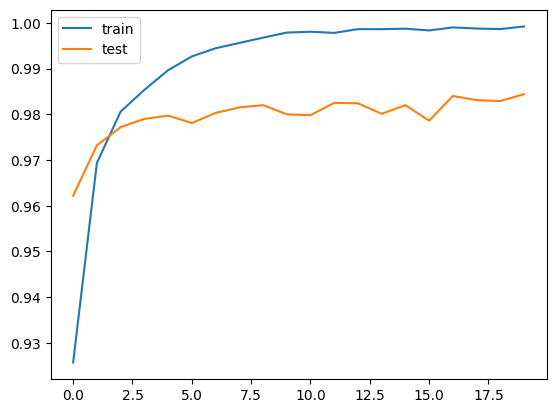

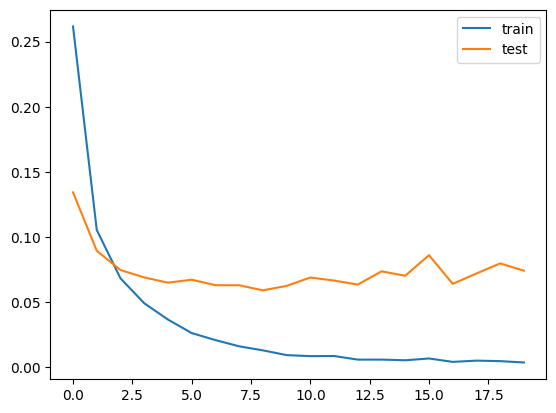

In [54]:
import matplotlib.pyplot as plt

plt.plot(h1.history['accuracy'], label = "train")
plt.plot(h1.history['val_accuracy'], label = "test")
plt.legend()
plt.show()

plt.plot(h1.history['loss'], label = "train")
plt.plot(h1.history['val_loss'], label = "test")
plt.legend()
plt.show()

- 베스트 모델 저장, 학습 중단 설정
  - 베스트 모델 : 학습 중에서 설정한 기준값이 가장 좋은 모델을 저장 (ModelCheckpoint())
  - 학습 모델 : 학습 중에 설정한 기준값이 만족하는 경우에 학습을 중지시키는 기능 (EarlyStopping())

In [55]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import os

# 모델을 저장할 폴더
model_dir = './model/'

# 만약에 해당 폴더가 없다면 폴더를 생성
if not os.path.exists(model_dir):
  os.mkdir(model_dir)

In [56]:
# {epoch:02d} : epoch 변수의 값을 2자리 정수로 출력
# {loss:.4f} : loss 변수의 값을 소수점 넷째 자리까지로 설정
# {val_loss:.4f} : val_loss 변수의 값을 소수점 넷째 자리까지로 설정
# 파일명 예시 : ./model/model1_20_0.894_0.876.hdf5
file_name = model_dir + "model1_{epoch:02d}_{loss:.4f}_{val_loss:.4f}.hdf5"

# 베스트 모델 저장 설정
# monitor : 베스트 모델을 결정하는 기준값
# save_best_only=True : monitor에서 설정한 기준값이 더 나아지는 경우에만 저장
mc = ModelCheckpoint(file_name, monitor='val_loss', save_best_only=True)

# 학습 중단 기능 : 얼마만큼 학습횟수를 설정할지 알 수 없기 때문에 학습이 더 나아지지 않는 경우에 자동 중지
# monitor : 학습 중단을 결정하는 기준값(가능하면 ModelCheckpoint와 동일한 값을 권장)
# patience : 학습이 더 나아지지 않더라도 기다려주는 횟수
es = EarlyStopping(monitor='val_loss', patience=5)

In [57]:
# callbacks : 반복할 때마다 호출되어 실행
h1 = model1.fit(X_train, y_train_oh, epochs = 40, batch_size = 128,
                validation_data=(X_test, y_test_oh),callbacks=[mc, es])

Epoch 1/40
469/469 [==============================] - 4s 9ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0691 - val_accuracy: 0.9838
Epoch 2/40
  9/469 [..............................] - ETA: 6s - loss: 0.0030 - accuracy: 0.9983    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


469/469 [==============================] - 6s 13ms/step - loss: 6.7367e-04 - accuracy: 0.9999 - val_loss: 0.0746 - val_accuracy: 0.9838
Epoch 3/40
469/469 [==============================] - 4s 9ms/step - loss: 2.0600e-04 - accuracy: 1.0000 - val_loss: 0.0708 - val_accuracy: 0.9851
Epoch 4/40
469/469 [==============================] - 5s 10ms/step - loss: 1.3314e-04 - accuracy: 1.0000 - val_loss: 0.0721 - val_accuracy: 0.9847
Epoch 5/40
469/469 [==============================] - 6s 12ms/step - loss: 1.0847e-04 - accuracy: 1.0000 - val_loss: 0.0725 - val_accuracy: 0.9853
Epoch 6/40
469/469 [==============================] - 5s 10ms/step - loss: 9.1880e-05 - accuracy: 1.0000 - val_loss: 0.0732 - val_accuracy: 0.9849


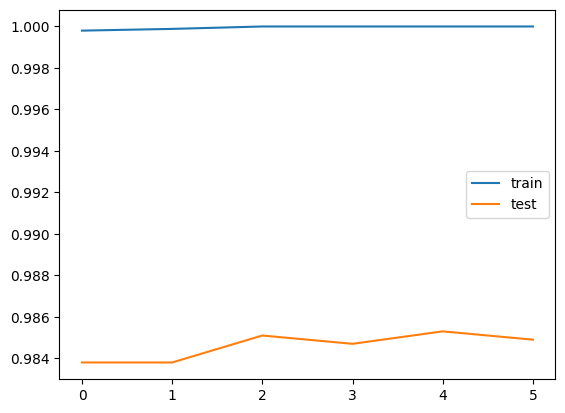

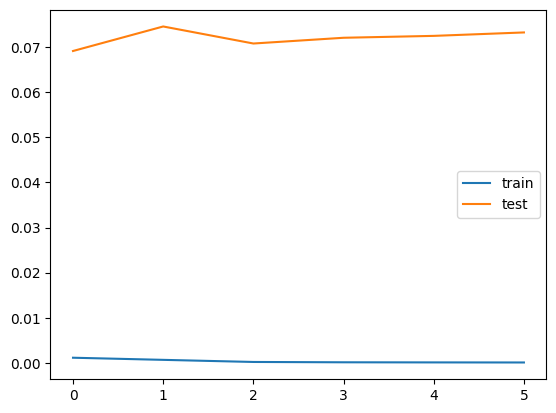

In [58]:
# 시각화
import matplotlib.pyplot as plt

plt.plot(h1.history['accuracy'], label = "train")
plt.plot(h1.history['val_accuracy'], label = "test")
plt.legend()
plt.show()

plt.plot(h1.history['loss'], label = "train")
plt.plot(h1.history['val_loss'], label = "test")
plt.legend()
plt.show()

- 모델 불러오기

In [59]:
from keras.models import load_model

file_name = './model/model1_02_0.0002_0.0710.hdf5'
model2 = load_model(file_name)

model2.evaluate(X_train, y_train_oh)
model2.evaluate(X_test, y_test_oh)

313/313 [==============================] - 1s 4ms/step - loss: 0.0710 - accuracy: 0.9837


[0.07097351551055908, 0.9836999773979187]

- 예측하기

In [60]:
pred = model2.predict(X_test[0:1])
print(pred)
# 가장 큰 값을 갖는 인덱스를 반환
print(pred.argmax())
# 실제값
print(y_test[0])

1/1 [==============================] - 0s 82ms/step
[[1.00478566e-11 5.69272819e-14 1.22564415e-11 1.37176333e-08
  4.68413025e-18 5.12984566e-13 1.58380427e-18 1.00000000e+00
  4.01840844e-12 5.57351443e-10]]
7
7


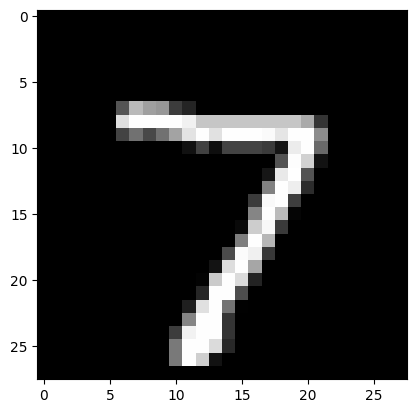

In [61]:
import matplotlib.pyplot as plt

plt.imshow(X_test[0].reshape(28,28), cmap='gray')
plt.show()

In [62]:
pred2 = model2.predict(X_test[23:24])
print(pred2)
# 가장 큰 값을 갖는 인덱스를 반환
print(pred2.argmax())

1/1 [==============================] - 0s 19ms/step
[[1.9305930e-19 4.4900181e-17 4.5395344e-16 2.3718495e-12 1.4273738e-20
  1.0000000e+00 2.4407074e-12 1.1894605e-23 3.1115498e-14 3.0523664e-15]]
5


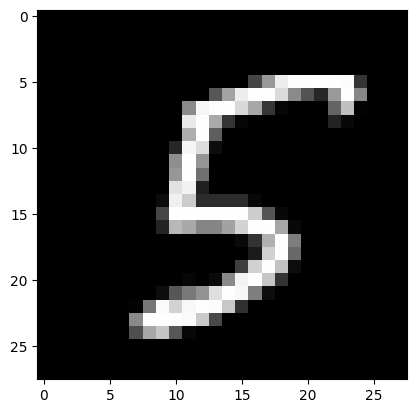

In [63]:
import matplotlib.pyplot as plt

plt.imshow(X_test[23].reshape(28,28), cmap='gray')
plt.show()

In [66]:
idx = 115

pred3 = model2.predict(X_test[idx:idx+1])
print(pred3)
# 가장 큰 값을 갖는 인덱스를 반환
print(pred3.argmax())
# 실제값
print(y_test[idx])

1/1 [==============================] - 0s 42ms/step
[[1.57969300e-08 2.11539657e-07 1.46726393e-07 1.13760244e-07
  1.20922051e-01 1.94321586e-07 6.02205073e-05 8.65985061e-09
  1.61549724e-06 8.79015446e-01]]
9
4


In [69]:
# 잘못 예측한 데이터 출력해보기
pred4 = model2.predict(X_test)

co = 0
failed = 0
for i in pred4 :
  if pred4[co].argmax() != y_test[co] :
    failed += 1
    print(co)
  co += 1

print("잘못 예측한 데이터 수 : ", failed)

313/313 [==============================] - 1s 3ms/step
115
149
247
321
340
445
449
495
582
659
684
720
947
951
956
965
1014
1039
1112
1156
1178
1182
1226
1232
1242
1247
1319
1328
1393
1395
1494
1522
1549
1609
1621
1681
1754
1790
1800
1878
1901
1941
1982
1984
1987
2004
2024
2043
2053
2070
2098
2109
2118
2130
2135
2182
2272
2293
2369
2387
2488
2597
2607
2648
2654
2720
2877
2896
2921
2927
2939
2953
3073
3117
3225
3422
3503
3520
3558
3567
3727
3751
3780
3796
3808
3818
3838
3853
3893
3906
3941
3943
4065
4140
4176
4199
4201
4248
4289
4294
4425
4433
4443
4497
4536
4551
4740
4751
4761
4807
4823
4860
4876
4879
4880
4966
5199
5331
5457
5564
5642
5676
5734
5936
5955
5973
6011
6023
6059
6166
6555
6559
6571
6574
6576
6597
6651
6755
6783
6847
7216
7434
8062
8094
8246
8325
8522
8527
9009
9015
9019
9024
9280
9587
9664
9679
9729
9745
9768
9770
9792
9839
9975
잘못 예측한 데이터 수 :  163


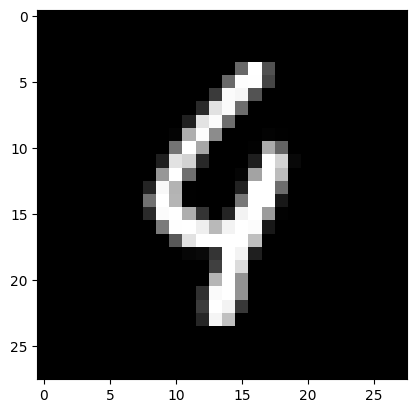

In [70]:
import matplotlib.pyplot as plt

plt.imshow(X_test[115].reshape(28,28), cmap='gray')
plt.show()

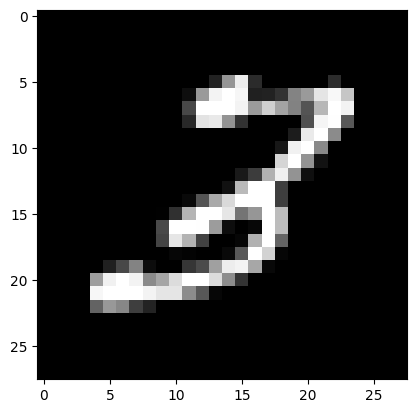

In [71]:
import matplotlib.pyplot as plt

plt.imshow(X_test[9975].reshape(28,28), cmap='gray')
plt.show()

In [72]:
idx = 9975

pred3 = model2.predict(X_test[idx:idx+1])
print(pred3)
# 가장 큰 값을 갖는 인덱스를 반환
print(pred3.argmax())
# 실제값
print(y_test[idx])

1/1 [==============================] - 0s 34ms/step
[[1.0022501e-09 2.1679043e-06 4.0550120e-04 4.6127445e-01 1.7654080e-11
  3.9278314e-07 2.4079991e-09 5.6440267e-04 5.3775287e-01 1.7006204e-07]]
8
3


- 내 손글씨 인식하기
  - 모델을 만들 때 수행했던 전처리를 그대로 해주어야 한다

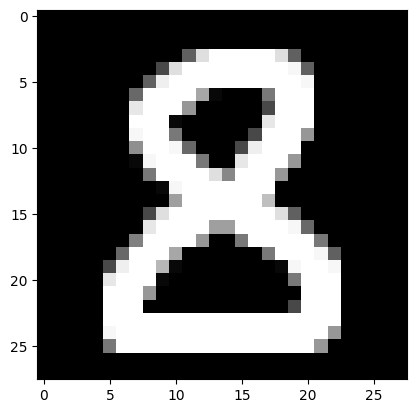

In [81]:
# 이미지 불러오기!
import PIL.Image as pimg
import numpy as np
import matplotlib.pyplot as plt

img = pimg.open('./data/8.png').convert('L') # convert('L') : 흑백으로 변환
plt.imshow(img, cmap="gray")
plt.show()

- 데이터 전처리
  - 데이터의 형태 : (1, 784)
  - 데이터의 값 : 0.0 - 1.0

In [82]:
img = np.array(img)
img.shape

(28, 28)

In [85]:
img

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  96, 223,
        255, 255, 255, 255, 255, 223,  96,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  72, 223, 255, 255,
        255, 255, 255, 255, 255, 255, 247,  96,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  96, 239, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 247,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 104, 255, 255, 255, 255, 167,
          8,   0,   0,   0, 120, 255, 255, 255,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 231, 255, 255, 255, 151,   0,
          0,   0,   0,   0,  72, 255, 255, 255,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 255, 255, 255,   8,   0,   0,
          0,   0,   0,   0, 231, 255, 255, 255,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 247, 255, 255, 120,   0,   0,
          0,   0,   0,  72, 255, 255, 255, 151,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 143, 255, 255, 247, 104,   0,
          0,   0,  72, 239, 255, 255, 255,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   8, 247, 255, 255, 255, 120,
          0,   0, 231, 255, 255, 255, 151,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 120, 255, 255, 255, 255,
        223, 135, 255, 255, 255, 151,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   8, 247, 255, 255,
        255, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 159, 255, 255,
        255, 255, 255, 255, 191,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  72, 223, 255, 255, 255,
        255, 255, 255, 255, 255, 223,  96,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 231, 255, 255, 255, 255,
        159, 159, 255, 255, 255, 255, 247, 104,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 128, 255, 255, 255, 255, 151,
          0,   0, 120, 255, 255, 255, 255, 255, 120,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0, 104, 255, 255, 255, 167,   0,   0,
          0,   0,   0,   0, 120, 255, 255, 255, 247,  96,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,  72, 239, 255, 255, 183,   8,   0,   0,
          0,   0,   0,   0,   0,   8, 247, 255, 255, 247,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 231, 255, 255, 255,   8,   0,   0,   0,
          0,   0,   0,   0,   0,   0, 120, 255, 255, 255,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 255, 255, 255, 151,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0, 255, 255, 255,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 255, 255, 255,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,  72, 255, 255, 255,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255, 255, 255, 255,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 247, 25

In [84]:
testimg = img.reshape(-1, 28*28)  # reshape할 때 -1 -> 차원이 하나 추가
testimg.shape

(1, 784)

In [86]:
testimg = testimg/255.0
testimg
# -> 0과 1 사이의 값으로 변경되었다!

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

In [87]:
pred = model2.predict(testimg)
print(pred)
print(pred.argmax())

1/1 [==============================] - 0s 42ms/step
[[3.5320172e-21 2.2439536e-16 2.1643447e-09 7.4426949e-01 2.6831348e-21
  4.3070485e-09 3.5898786e-16 1.2256530e-21 2.5573045e-01 3.2253342e-15]]
3


In [103]:
img2 = pimg.open('./data/6.png').convert('L') # convert('L') : 흑백으로 변환
img2 = np.array(img2)
img2.shape

testimg2 = img2.reshape(-1, 28*28)  # reshape할 때 -1 -> 차원이 하나 추가

testimg2 = testimg2/255.0

pred2 = model2.predict(testimg2)
print(pred2)
print(pred2.argmax())

1/1 [==============================] - 0s 33ms/step
[[1.7687051e-15 1.8289197e-15 9.9566454e-01 3.3759711e-14 3.0311348e-10
  4.6208336e-07 4.3350100e-03 1.6395076e-23 1.5845434e-12 1.0347993e-13]]
2


In [99]:
img2

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,  96, 223, 223,  96,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 128, 255, 255, 255, 247,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         96, 223, 255, 255, 255, 255, 151,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  96, 223,
        255, 255, 255, 255, 183,   8,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  72, 223, 255, 255,
        255, 255, 255, 167,   8,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 231, 255, 255, 255,
        255, 167,   8,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 128, 255, 255, 255, 167,
          8,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 104, 255, 255, 255, 167,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  72, 239, 255, 255, 183,   8,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0, 231, 255, 255, 255,   8,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0, 255, 255, 255, 151,   0,   0,   0,
         96, 223, 255, 255, 255, 223,  96,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0, 255, 255, 255,   0,  16, 128, 223,
        255, 255, 255, 255, 255, 255, 247,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,  72, 255, 255, 255, 255, 255, 255, 255,
        255, 167,   8,   0, 255, 255, 255,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,  72, 223, 255, 255, 255, 255, 255, 255, 223,  96,
          0,   0,   0,  72, 255, 255, 255,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,  72, 239, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 255,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0, 231, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
        255, 255, 255, 255, 255, 255, 151,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0, 247, 255, 255, 151,   0,   0,   8, 159, 255, 255, 255,
        255, 255, 255, 255, 255, 151,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0, 120, 255, 151,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   

In [94]:
img3 = pimg.open('./data/0.png').convert('L') # convert('L') : 흑백으로 변환
img3 = np.array(img3)
img3.shape

testimg3 = img3.reshape(-1, 28*28)  # reshape할 때 -1 -> 차원이 하나 추가

testimg3 = testimg/255.0

pred3 = model1.predict(testimg3)
print(pred3)
print(pred3.argmax())

1/1 [==============================] - 0s 156ms/step
[[0.0305531  0.05095506 0.11071106 0.02462695 0.10176802 0.4020477
  0.08817317 0.05765213 0.08416648 0.04934638]]
5


- 과적합 방지
  - Dropout()
    - 각 층의 퍼셉트론의 수를 설정한 비율만큼 제한 -> 각 반복마다 적용되는 퍼셉트론은 랜덤으로 선택
    - 제한 비율은 0.5 이하로 설정 -> 0.5 이상이면 해당 층의 신경망이 가지는 특성이 효과적으로 적용되지 못하기 때문
    - 퍼셉트론의 수가 감소 -> 파라미터의 수가 감소 -> 복잡도가 감소 -> 과적합 감소

In [104]:
import pandas as pd

# 특성 60개로 구성
# 암석에서 음파를 쏴서 반사하는 파를 확인해서 금속을 탐지
# header=None -> 원본 파일에 열 이름이 없는 데이터
sonar = pd.read_csv('./data/sonar.csv', header=None)
sonar.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [105]:
# 라벨 데이터 확인
sonar[60].value_counts()
# M -> Metal / R -> Rock

60
M    111
R     97
Name: count, dtype: int64

In [106]:
import tensorflow as tf

# seed -> 다른 컴퓨터에서 작업을 하더라도 w와 b값이 같은 값으로 초기화
# 모델을 개선했을 때 모델의 성능을 판별
seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)

In [109]:
# 특성 / 라벨 데이터 분리
X = sonar.iloc[:,0:60]
y = sonar.iloc[:,60]

X.shape, y.shape

((208, 60), (208,))

- 라벨 데이터 인코딩
  - M, R의 문자 형태로 되어 있는 라벨을 숫자로 변환 -> 라벨 인코딩
  - 0부터 숫자가 부여, 알파벳 순

In [110]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y)
y_en = encoder.transform(y)

In [112]:
# 훈련 / 검증 데이터로 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_en, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((166, 60), (42, 60), (166,), (42,))

In [113]:
y_en

# M -> 0 / R -> 1

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

- 모델 설계
- 컴파일
- 학습 (베스트모델 저장, 학습중단)
- 저장된 모델 불러오기
- 불러온 모델로 예측하기(X_test)

In [126]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model3 = Sequential()

# 입력층
model3.add(Dense(512, activation='relu', input_dim=60))

# 은닉층
model3.add(Dense(256, activation = 'relu'))
model3.add(Dense(128, activation = 'relu'))
model3.add(Dense(64, activation = 'relu'))

# 인코딩 : 퍼셉트론 수 (특성 수)를 감소시켜가는 방식 (압축, 정보 요약, 중요 특성 추출/선택)
# 디코딩 : 퍼셉트론 수 (특성 수)를 증가시켜가는 방식 (복원)

# 출력층
# 원핫 인코딩하지 않았기 때문에 -> 퍼셉트론 수 1, 활성화함수 sigmoid
# 원핫 인코딩 했다면 -> 퍼셉트론 수 2, 활성화함수 softmax
model3.add(Dense(1, activation = 'sigmoid'))

model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 512)               31232     
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 dense_16 (Dense)            (None, 128)               32896     
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 dense_18 (Dense)            (None, 1)                 65        
                                                                 
Total params: 203777 (796.00 KB)
Trainable params: 203777 (796.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [127]:
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [129]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import os

file_name = model_dir + "model3_{epoch:02d}_{loss:.4f}_{val_loss:.4f}.hdf5"

mc = ModelCheckpoint(file_name, monitor='val_loss', save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=10)

In [130]:
h3 = model3.fit(X_train,y_train, epochs=200, batch_size=16,
              validation_data=(X_test, y_test), callbacks=[mc, es])

Epoch 1/200
11/11 [==============================] - 0s 21ms/step - loss: 0.3444 - accuracy: 0.8373 - val_loss: 0.4491 - val_accuracy: 0.7857
Epoch 2/200
11/11 [==============================] - 0s 9ms/step - loss: 0.3408 - accuracy: 0.7771 - val_loss: 0.5242 - val_accuracy: 0.7143
Epoch 3/200
 1/11 [=>............................] - ETA: 0s - loss: 0.3342 - accuracy: 0.8750

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 0s 9ms/step - loss: 0.3077 - accuracy: 0.8554 - val_loss: 0.5600 - val_accuracy: 0.7619
Epoch 4/200
11/11 [==============================] - 0s 12ms/step - loss: 0.2377 - accuracy: 0.9157 - val_loss: 0.6033 - val_accuracy: 0.6667
Epoch 5/200
11/11 [==============================] - 0s 12ms/step - loss: 0.2190 - accuracy: 0.9157 - val_loss: 0.4388 - val_accuracy: 0.8095
Epoch 6/200
11/11 [==============================] - 0s 9ms/step - loss: 0.2074 - accuracy: 0.9157 - val_loss: 0.7379 - val_accuracy: 0.6905
Epoch 7/200
11/11 [==============================] - 0s 8ms/step - loss: 0.2164 - accuracy: 0.8916 - val_loss: 0.4469 - val_accuracy: 0.8333
Epoch 8/200
11/11 [==============================] - 0s 12ms/step - loss: 0.1385 - accuracy: 0.9578 - val_loss: 0.4170 - val_accuracy: 0.8810
Epoch 9/200
11/11 [==============================] - 0s 8ms/step - loss: 0.1409 - accuracy: 0.9398 - val_loss: 0.4234 - val_accuracy: 0.8095
Epoch 10/200
11/11 [==

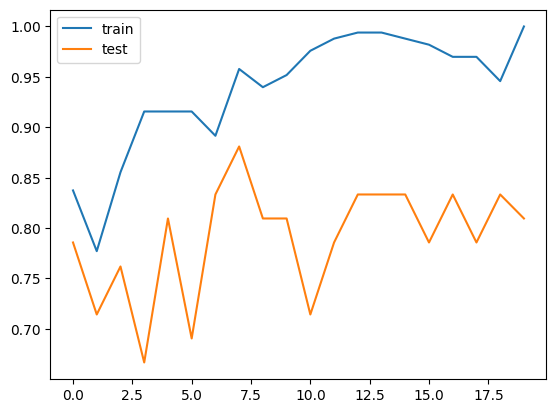

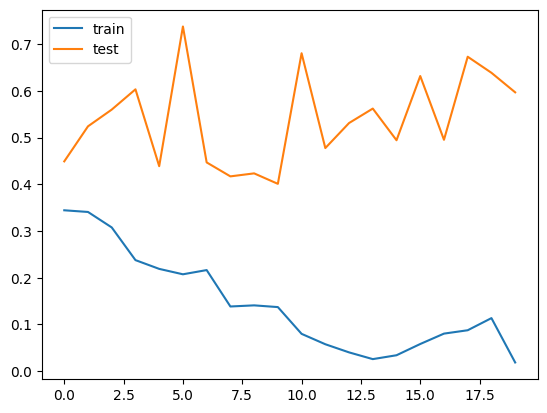

In [131]:
# 시각화
import matplotlib.pyplot as plt

plt.plot(h3.history['accuracy'], label = "train")
plt.plot(h3.history['val_accuracy'], label = "test")
plt.legend()
plt.show()

plt.plot(h3.history['loss'], label = "train")
plt.plot(h3.history['val_loss'], label = "test")
plt.legend()
plt.show()

- Dropout 추가해보기

In [132]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

model4 = Sequential()

# 입력층
model4.add(Dense(512, activation='relu', input_dim=60))

# 은닉층
model4.add(Dropout(0.3))
model4.add(Dense(256, activation = 'relu'))
model4.add(Dropout(0.3))
model4.add(Dense(128, activation = 'relu'))
model4.add(Dropout(0.3))
model4.add(Dense(64, activation = 'relu'))

# 출력층
model4.add(Dense(1, activation = 'sigmoid'))

model4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 512)               31232     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 64)               

In [133]:
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [135]:
h4 = model4.fit(X_train, y_train, epochs=200,batch_size=16,
                validation_data=(X_test,y_test))

Epoch 1/200
11/11 [==============================] - 1s 28ms/step - loss: 0.6988 - accuracy: 0.4940 - val_loss: 0.7069 - val_accuracy: 0.4524
Epoch 2/200
11/11 [==============================] - 0s 9ms/step - loss: 0.6796 - accuracy: 0.5783 - val_loss: 0.6526 - val_accuracy: 0.6429
Epoch 3/200
11/11 [==============================] - 0s 8ms/step - loss: 0.6295 - accuracy: 0.6566 - val_loss: 0.7246 - val_accuracy: 0.5952
Epoch 4/200
11/11 [==============================] - 0s 8ms/step - loss: 0.5933 - accuracy: 0.6687 - val_loss: 0.7229 - val_accuracy: 0.6667
Epoch 5/200
11/11 [==============================] - 0s 9ms/step - loss: 0.5638 - accuracy: 0.7410 - val_loss: 0.5043 - val_accuracy: 0.7381
Epoch 6/200
11/11 [==============================] - 0s 8ms/step - loss: 0.4896 - accuracy: 0.7349 - val_loss: 0.6589 - val_accuracy: 0.6667
Epoch 7/200
11/11 [==============================] - 0s 9ms/step - loss: 0.4498 - accuracy: 0.8012 - val_loss: 0.6081 - val_accuracy: 0.7619
Epoch 8/200


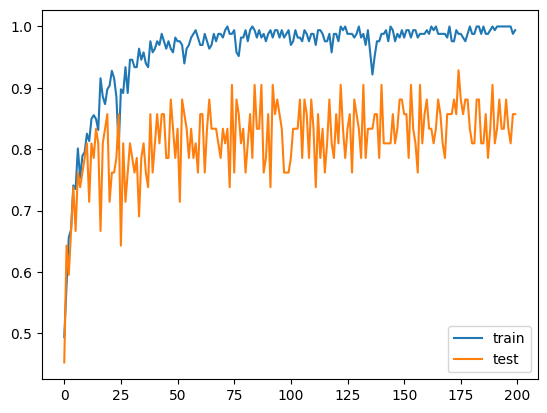

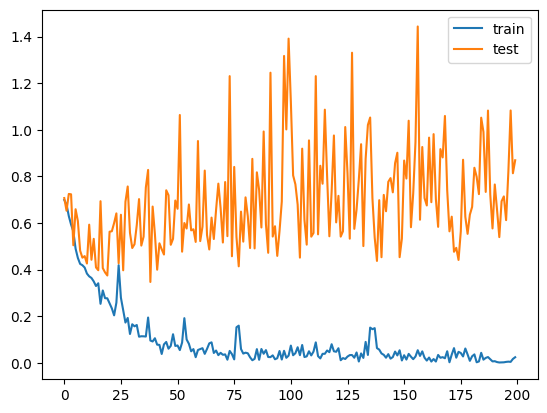

In [136]:
# 시각화
import matplotlib.pyplot as plt

plt.plot(h4.history['accuracy'], label = "train")
plt.plot(h4.history['val_accuracy'], label = "test")
plt.legend()
plt.show()

plt.plot(h4.history['loss'], label = "train")
plt.plot(h4.history['val_loss'], label = "test")
plt.legend()
plt.show()

In [137]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model5 = Sequential()

# 입력층
model5.add(Dense(512, activation='relu', input_dim=60))

# 은닉층
model5.add(Dense(256, activation = 'relu'))
model5.add(Dense(128, activation = 'relu'))
model5.add(Dense(64, activation = 'relu'))

# 출력층
# 원핫 인코딩하지 않았기 때문에 -> 퍼셉트론 수 1, 활성화함수 sigmoid
# 원핫 인코딩 했다면 -> 퍼셉트론 수 2, 활성화함수 softmax
model5.add(Dense(1, activation = 'sigmoid'))

model5.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 512)               31232     
                                                                 
 dense_25 (Dense)            (None, 256)               131328    
                                                                 
 dense_26 (Dense)            (None, 128)               32896     
                                                                 
 dense_27 (Dense)            (None, 64)                8256      
                                                                 
 dense_28 (Dense)            (None, 1)                 65        
                                                                 
Total params: 203777 (796.00 KB)
Trainable params: 203777 (796.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [138]:
model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [139]:
h5 = model5.fit(X_train,y_train, epochs=200, batch_size=16,
              validation_data=(X_test, y_test))

Epoch 1/200
11/11 [==============================] - 1s 28ms/step - loss: 0.6877 - accuracy: 0.5301 - val_loss: 0.6632 - val_accuracy: 0.5952
Epoch 2/200
11/11 [==============================] - 0s 8ms/step - loss: 0.6103 - accuracy: 0.7169 - val_loss: 0.6521 - val_accuracy: 0.6905
Epoch 3/200
11/11 [==============================] - 0s 8ms/step - loss: 0.4992 - accuracy: 0.7952 - val_loss: 0.6080 - val_accuracy: 0.7381
Epoch 4/200
11/11 [==============================] - 0s 7ms/step - loss: 0.4421 - accuracy: 0.7530 - val_loss: 0.5776 - val_accuracy: 0.7381
Epoch 5/200
11/11 [==============================] - 0s 8ms/step - loss: 0.4106 - accuracy: 0.8193 - val_loss: 0.5063 - val_accuracy: 0.7857
Epoch 6/200
11/11 [==============================] - 0s 8ms/step - loss: 0.4105 - accuracy: 0.8133 - val_loss: 0.5295 - val_accuracy: 0.6667
Epoch 7/200
11/11 [==============================] - 0s 7ms/step - loss: 0.3185 - accuracy: 0.8795 - val_loss: 0.5284 - val_accuracy: 0.7143
Epoch 8/200


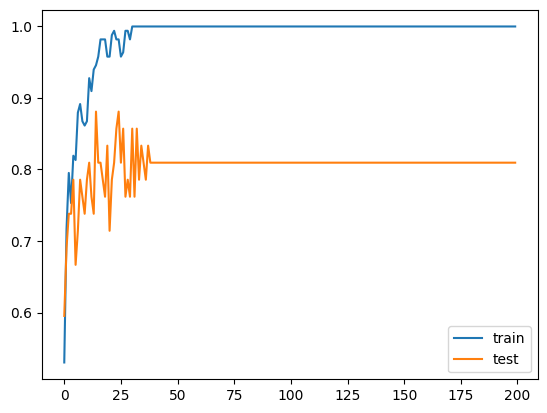

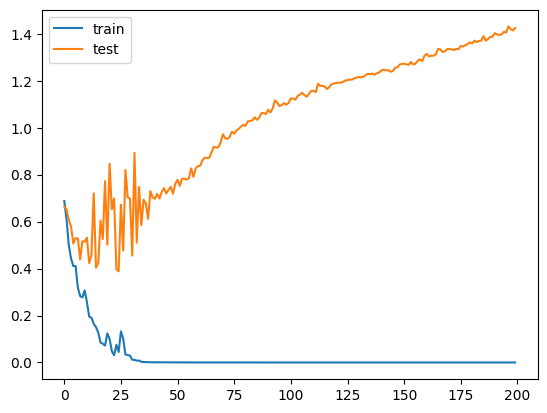

In [141]:
# 시각화
import matplotlib.pyplot as plt

plt.plot(h5.history['accuracy'], label = "train")
plt.plot(h5.history['val_accuracy'], label = "test")
plt.legend()
plt.show()

plt.plot(h5.history['loss'], label = "train")
plt.plot(h5.history['val_loss'], label = "test")
plt.legend()
plt.show()